In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import SRW_v044 as SRW
from scipy.sparse import csr_matrix, csc_matrix, issparse
import functools
from base_network import make_network

In [26]:
nsamples = 100
nnodes = 1000
edge_freq = 0.004
cliq_edge_freq = 0.114
hi_mut_freq = 0.5
hi_node = nnodes*3/4
group_labels = ['Subtype 1']*(nsamples//2) + ['Subtype 2']*(nsamples//2)
feature_names = ['Subnetwork 1', 'Subnetwork 2', 'High mut source', 'High mut target', 
                 'Random 1', 'Random 2', 
                 'Self loop', 'Intercept']
node_names = ['{}'.format(i) for i in range(1,nnodes+1)]
sample_names = ['{}'.format(i) for i in range(1,nsamples+1)]

rand_mut_freq = 0.015

In [27]:
rst_prob = 0.3
lam = 1e-1
WMW_b = 2e-4

In [28]:
network_type = 'cliq_random' # 'random', 'scale_free', 'small_world', 'cliq_random'
edges, features = make_network(network_type, nnodes, edge_freq, cliq_edge_freq)

P_init = []
for p in range(nsamples):
    p_init = []
    for i in range(nnodes):
        freq=0
        if p == i:
            freq = 1
        elif i == hi_node:
            freq = hi_mut_freq
        elif i<100:
            if (max(p,i)<50 or min(p,i)>=50):
                freq = 0.015
            else:
                freq = 0.000
        else:
            freq = rand_mut_freq

        if np.random.random() < freq:
            p_init.append(1)
        else:
            p_init.append(0)

    P_init.append(p_init)
P_init = csr_matrix(P_init)

SRW_obj = SRW.SRW_solver(edges, features, nnodes, P_init, rst_prob, group_labels, lam, w_init_sd=0.01, 
                         w=None, feature_names=feature_names, sample_names=sample_names, 
                         node_names=node_names, loss='WMW', norm_type='L1', learning_rate=0.5, 
                         update_w_func='Adam', P_init_val=P_init, group_labels_val=group_labels, 
                         ncpus=len(feature_names), maxit=1000, early_stop=10, WMW_b=WMW_b)
SRW_obj.train_SRW_GD()

finished calculating strength_grad: 17:03:31
finished network propagation: 17:03:31
finished calculating P_grad using pool: 17:03:32
finished calculating J and J_grad: 17:03:32
*** 0 iteration: J is 43.81504871157903 cost_val is 9.390772942422755
*** accuracy is 0.56 accuracy_val is 1.0


finished calculating strength_grad: 17:03:33
finished network propagation: 17:03:33
finished calculating P_grad using pool: 17:03:34
finished calculating J and J_grad: 17:03:34
*** 1 iteration: J is 43.04598614583435 cost_val is 8.398387244670175
*** accuracy is 0.6 accuracy_val is 1.0


finished calculating strength_grad: 17:03:35
finished network propagation: 17:03:35
finished calculating P_grad using pool: 17:03:37
finished calculating J and J_grad: 17:03:37
*** 2 iteration: J is 41.655704393085855 cost_val is 7.200476634147215
*** accuracy is 0.63 accuracy_val is 1.0


finished calculating strength_grad: 17:03:37
finished network propagation: 17:03:37
finished calculating P_grad using pool: 17:03:

In [29]:
SRW_obj.w_map

,Weight
Subnetwork 1,4.465885
Subnetwork 2,4.409921
High mut source,0.285493
High mut target,0.164413
Random 1,-1.841117
Random 2,-2.125196
Self loop,-0.394355
Intercept,-4.056357


In [30]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
SRW_obj.w = SRW_obj.w_list[0]
SRW_obj.map_w()
SRW_obj.w[-1] = 100
SRW_obj.w[-2] = -200
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
P_df = SRW_obj.P_fin_df.copy()
P_df_pca = pca.fit_transform(P_df)
explained_variance_ratio = pca.explained_variance_ratio_


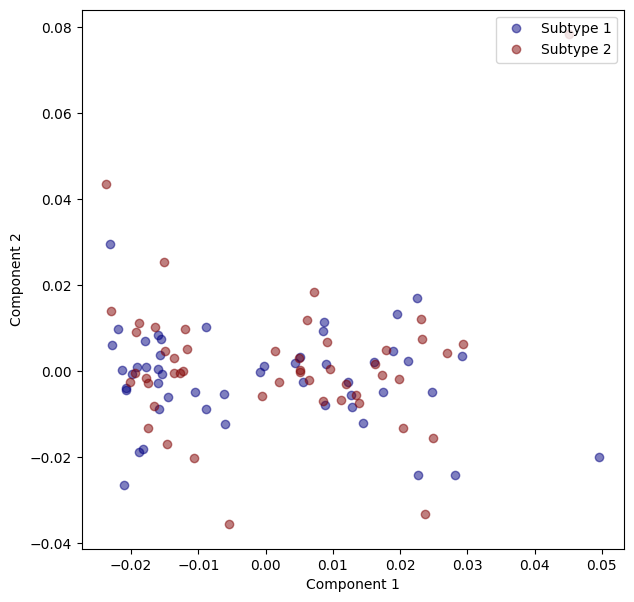

In [33]:
X = pd.DataFrame(P_df_pca, columns=['PC1', 'PC2'])
X['labels'] = group_labels

labels = X.groupby('labels')

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
from cycler import cycler
ax.set_prop_cycle(cycler('color', colors))

for name, label in labels:
    ax.plot(label.PC1, label.PC2, alpha=0.5, marker='o', linestyle='', label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
ax.legend(loc='upper right')

plt.savefig('data/sim1001000_0_PCA.pdf')
plt.show()

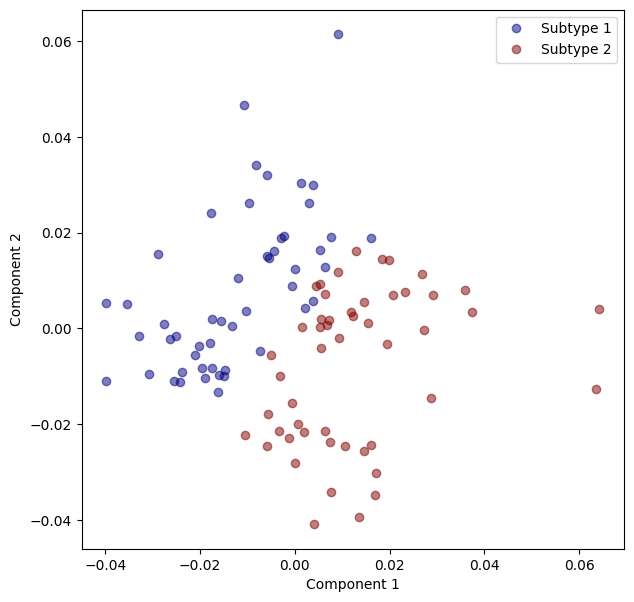

In [34]:
SRW_obj.w = SRW_obj.w_list[-1]
SRW_obj.map_w()
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

pca = PCA(n_components=2)
P_df = SRW_obj.P_fin_df.copy()
P_df_pca = pca.fit_transform(P_df)
explained_variance_ratio = pca.explained_variance_ratio_

X = pd.DataFrame(P_df_pca, columns=['PC1', 'PC2'])
X['labels'] = group_labels

labels = X.groupby('labels')

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_prop_cycle(cycler('color', colors))
for name, label in labels:
    ax.plot(label.PC1, label.PC2, alpha=0.5, marker='o', linestyle='', label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
ax.legend(loc='upper right')

plt.savefig('data/sim1001000_-1_PCA.pdf')

plt.show()

In [35]:
P_df

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
1,0.023126,0.005886,0.005937,0.004267,0.001245,0.001922,0.000356,0.002010,0.002803,0.003579,...,0.001623,0.000233,0.000277,0.0,0.000255,0.000121,0.001158,0.000793,0.000055,9.056067e-06
2,0.000490,0.017410,0.000630,0.003287,0.000991,0.005623,0.000411,0.002371,0.000478,0.001821,...,0.000117,0.000425,0.000111,0.0,0.000108,0.000098,0.001282,0.000123,0.015261,1.493170e-02
3,0.000166,0.002085,0.031991,0.001914,0.000881,0.002070,0.000175,0.001276,0.008171,0.001318,...,0.000093,0.001040,0.000044,0.0,0.001018,0.000018,0.000100,0.000445,0.000137,8.634057e-07
4,0.000173,0.001825,0.002433,0.027068,0.000645,0.001471,0.000440,0.002179,0.001713,0.000956,...,0.000087,0.002144,0.000132,0.0,0.000077,0.001281,0.000540,0.001681,0.000075,4.224358e-06
5,0.000425,0.001871,0.001480,0.004541,0.020274,0.003168,0.000248,0.001754,0.000870,0.002081,...,0.001258,0.000252,0.000154,0.0,0.000430,0.000199,0.001195,0.000327,0.000074,1.959133e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000163,0.000714,0.005268,0.001766,0.000350,0.000944,0.000424,0.000678,0.002020,0.000832,...,0.000274,0.000188,0.000100,0.0,0.004485,0.000056,0.000110,0.000703,0.000036,8.963388e-07
97,0.000191,0.004907,0.000670,0.002072,0.000257,0.001792,0.005522,0.001841,0.000692,0.000904,...,0.000396,0.000108,0.000111,0.0,0.000121,0.000043,0.000053,0.001169,0.000020,4.876087e-07
98,0.000700,0.000549,0.019544,0.001150,0.000511,0.000955,0.000249,0.000591,0.008440,0.000477,...,0.000124,0.000058,0.000503,0.0,0.000502,0.000029,0.000028,0.000075,0.000148,2.814742e-07
99,0.000303,0.000842,0.004720,0.001130,0.001621,0.000789,0.000209,0.000658,0.001487,0.000950,...,0.000064,0.000337,0.000157,0.0,0.000166,0.000069,0.000172,0.000377,0.000243,1.417130e-06


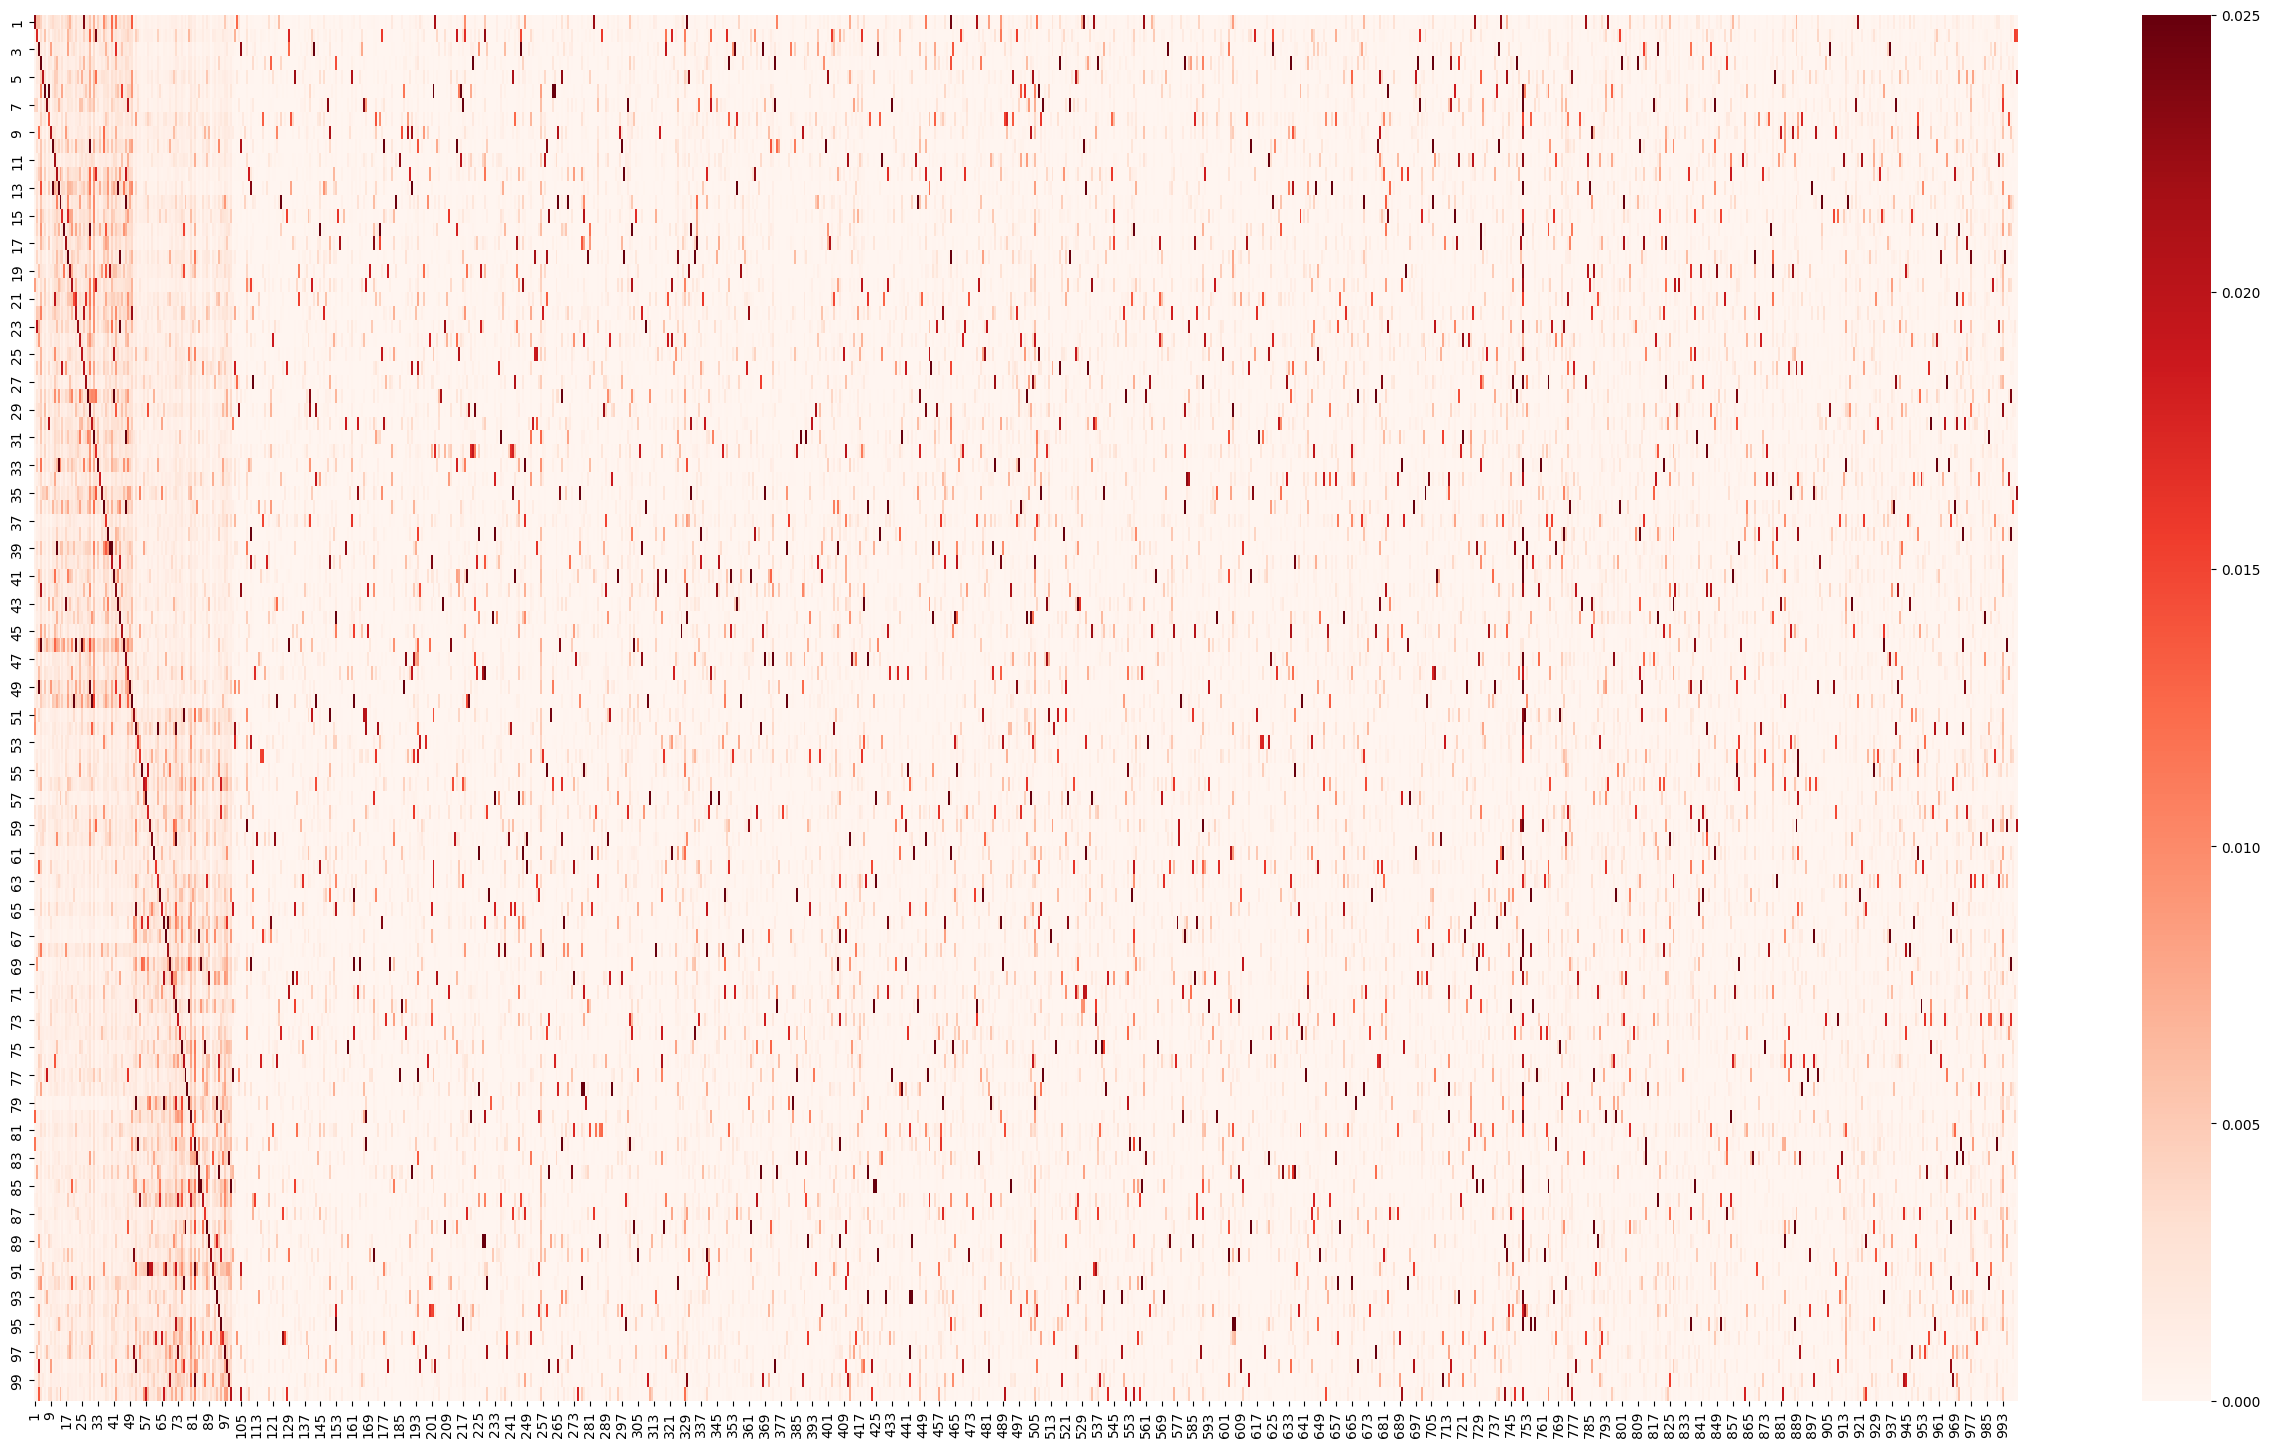

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(32,18))
ax = sns.heatmap(P_df.clip(upper=0.025),cmap='Reds', square=False)
plt.savefig('data/sim1001000_P_df.pdf')